In [1]:
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
from PIL import Image
import glob 


In [10]:
import pandas as pd

df = pd.read_excel ('./multilabels/new_LandUse_Multilabeled.xlsx')
df_label = np.array(df)



In [3]:
class_names =  np.array(["airplane","bare-soil","buildings","cars","chaparral","court","dock","field","grass","mobile-home","pavement","sand","sea","ship","tanks","trees","water"])


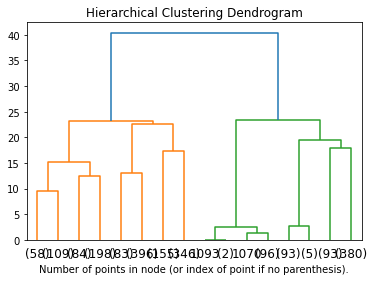

In [4]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()
X = df_label[:,1:]

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [5]:
largestxor = 0 
largestij = (0,0)

for i in range(1,17):
    for j in range(i+1,18):
        #colnand = np.sum(np.logical_not(np.logical_and(df_label[:,i], df_label[:,j])))
        colxor = np.sum(np.logical_xor(df_label[:,i].astype(bool) , df_label[:,j].astype(bool) )) -  np.sum(np.logical_and(df_label[:,i], df_label[:,j]))
        #print(i,j, colxor, colnand)
        if colxor >= largestxor and np.sum(df_label[:,i]) >=700 and np.sum(df_label[:,j])>= 700 :
            largestxor = colxor
            largestij = (i,j)
print(largestxor,class_names[largestij[0]-1], class_names[largestij[1]-1], largestij)

674 bare-soil cars (2, 4)


In [6]:
def uncor_selecter(nr_label = 4,min_img = 300):
    """retrun a list with the least correlated labels """
    image_perlabel = np.sum(df_label[:,1:],axis= 0)
    biggest_label =np.where(np.any([image_perlabel > min_img],axis=0))[0]
    print(biggest_label, image_perlabel[biggest_label])

    selected_list = [] 
    allcor_lost = np.array([0,0,0])
    for i in range(0,len(biggest_label)-1):
        it = biggest_label[i]
        for j in range(i+1,len(biggest_label)):
            jt = biggest_label[j]

            colxor = np.sum(np.logical_xor(df_label[:,it].astype(bool) , df_label[:,jt].astype(bool) )) -  np.sum(np.logical_and(df_label[:,it], df_label[:,jt]))
            allcor_lost = np.vstack((allcor_lost, np.array([colxor,it,jt]))) 
    sorted_list = allcor_lost[allcor_lost[:,0].argsort()]
    selected_list.append(sorted_list[-1,1])
    selected_list.append(sorted_list[-1,2])
    #print(sorted_list, selected_list)        

    while len(selected_list)<nr_label:
        biggest_label = np.setdiff1d(biggest_label,np.array(selected_list))
        largestxor = 0 
        largestind = 0
        for i in biggest_label:
            overall_xor = 0 
            for j in (selected_list):
                overall_xor += np.sum(np.logical_xor(df_label[:,i].astype(bool) , df_label[:,j].astype(bool) )) -  np.sum(np.logical_and(df_label[:,i], df_label[:,j]))

            if overall_xor >= largestxor:
                largestxor = overall_xor
                largestind = i

        selected_list.append(largestind)
    
    return selected_list


trylist = uncor_selecter(3, 300)
print(type(trylist), trylist)
            
            


[ 1  2  3  8 10 15] [718 691 886 975 1300 1009]
<class 'list'> [1, 2, 3]


In [7]:
import random
def sampler_split_for_client(cdata, idxs, nr_client= 4, minimum_skew_percentage = .4):
    selected_labels = uncor_selecter(nr_client,300)
    
    splitlists = []
    for sb in selected_labels:
        splitlists.append([])
        
    
    for i in idxs:
        nplabel = cdata.__getlabel__(i)
        #nplabel = label.numpy()
        
        if np.any(nplabel[selected_labels] == 1):
            if random.random() < minimum_skew_percentage:
                
                flip = np.random.randint(np.sum(nplabel[selected_labels] == 1)) 
                mask = np.where(nplabel[selected_labels] == 1)[0][flip]
                splitlists[mask].append(i)
            
            else:
                flip = np.random.randint(nr_client) 
                splitlists[flip].append(i)
                    
        else:
            flip = np.random.randint(nr_client) 
            splitlists[flip].append(i)

    
    for alist in splitlists:
        print(len(alist))
    return splitlists
    


In [8]:
from torch.utils.data import Dataset
from natsort import natsorted

class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform, labelmat):
        self.main_dir = main_dir
        self.transforms = transform
        self.all_imgs = glob.glob(os.path.join(main_dir, '**/*.tif'), recursive=True)
        self.total_imgs = natsorted(self.all_imgs)
        self.xlabels = labelmat
        
    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        #print(idx,len(self.total_imgs))
        img_loc = self.total_imgs[idx]
        #print(img_loc)
        imagebaselabel = os.path.splitext(os.path.basename(img_loc))[0]
        label = self.xlabels[np.where(self.xlabels[:,0] == imagebaselabel),1:].reshape(17).astype(np.int64)
        #print(label,label.shape)
        tensor_label =  torch.from_numpy(label)
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transforms(image)
        return tensor_image, tensor_label
    
    def __getlabel__(self, idx):
        
        img_loc = self.total_imgs[idx]
        #print(img_loc)
        imagebaselabel = os.path.splitext(os.path.basename(img_loc))[0]
        label = self.xlabels[np.where(self.xlabels[:,0] == imagebaselabel),1:].reshape(17).astype(np.int64)
        
        return label

In [11]:


data_dir = './UCMerced_LandUse/images'
def load_split_train_test(datadir, labelmat,valid_size = .2):
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    train_data = CustomDataSet(datadir, transform=train_transforms, labelmat=labelmat)
    test_data = CustomDataSet(datadir, transform=train_transforms, labelmat=labelmat)
    print(train_data.__len__())
    indices = list(range(2100))
    split = int(np.floor(valid_size * 2100))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    
    
    lists = sampler_split_for_client(train_data, train_idx,3,.4)
    
    
    test_sampler = SubsetRandomSampler(test_idx)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=4)     
    
    client_loaders = []
    for indlist in lists:
        train_sampler = SubsetRandomSampler(indlist)
        trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=4)
        
        client_loaders.append(trainloader)


    
        
    return client_loaders,testloader
trainloaders, valloader  = load_split_train_test(data_dir, df_label,.2)


4200
[ 1  2  3  8 10 11 15 16] [1436 1382 1772 1950 2600 588 2018 406]
576
547
557


In [24]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=1, phase = 'train'):
    tloss, tacc= [] , []
    vloss, vacc= [] , []
    
    since = time.time()

    #best_model_wts = copy.deepcopy(model.state_dict())
    #best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        if True:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #_, preds = torch.max(outputs, 1)
                    outputcpu = outputs.cpu()
                    preds = np.heaviside(outputcpu.detach().numpy(),0)
                    #print(outputs, preds)
                    loss = criterion(outputs, labels.type(torch.float))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                    #outputsnp = outputs.cpu().numpy()
                    #preds = np.array(outputsnp > 0.5, dtype=float)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += ((torch.sum(torch.from_numpy(preds).to(device) == labels.data)).item() / len(class_names))
                #print("running_corrects",running_corrects)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders.dataset)
            epoch_acc = (running_corrects) / len(dataloaders.dataset)
            
            if phase == 'train':
                tloss.append(epoch_loss)
                tacc.append(epoch_acc)
            
            if phase == 'val':
                vloss.append(epoch_loss)
                vacc.append(epoch_acc)
            
            #print(dataset_sizes[phase],epoch_acc)
            #print(type(epoch_loss),type(epoch_acc))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    #model.load_state_dict(best_model_wts)
    return copy.deepcopy(model),[tloss,tacc,vloss,vacc]

In [14]:
class LENET(nn.Module):
    def __init__(self, n_classes):
        super(LENET, self).__init__()
        from collections import OrderedDict
        self.conv1 = nn.Conv2d(3, 16, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(5, 5))
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(5, 5))
        #self.conv4 = nn.Conv2d(64, 128, kernel_size=(5, 5))
        self.linear1 = nn.Linear(64 * 24 * 24, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, n_classes)                                
    def forward(self, x):
        """
        Args:
          x of shape (batch_size, 1, 28, 28): Input images.
        
        Returns:
          y of shape (batch_size, 10): Outputs of the network.
        """
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=2, stride=2)
        #x = F.max_pool2d(F.relu(self.conv4(x)), kernel_size=2, stride=2)
        x = x.view(-1, 64 * 24 * 24)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = LENET(len(class_names))
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [27]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model = model_ft.to(device)

criterion = nn.BCEWithLogitsLoss()


# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [28]:
def train_fedavg_model(model, device, clients, optimizer, criterion, scheduler, c_fraction, epochs=10):
    # iterate through epochs
    for i in range(epochs):
        # get random subset of clients
        #fraction = int( c_fraction * float(len(clients_t)) )
        #client_subset = random.sample(clients, fraction)
        
        # train each of the clients
        models_client_list = []
        print("Running epoch numero " + str(i))
        for dataloaders in clients:
            model_for_client = copy.deepcopy(model)
            client_model, statistics = train_model(model_for_client, dataloaders, criterion, optimizer, scheduler, num_epochs=1, phase = 'train')
            models_client_list.append(client_model)
            print("Done with clientelo numero whateva", statistics)
        
        # still need to average 
        # average clients params
        # model = sum(k for 1 - num_clients): ( data_client / total_num_data ) * model_client_k
        
        _, statistics = train_model(model, valloader, criterion, optimizer, scheduler, num_epochs=1, phase = 'val')
        print("Done with validation", statistics)

        
    return 0

C_FRACTION = 0.7
model = train_fedavg_model(model, device, trainloaders, optimizer_ft, criterion, exp_lr_scheduler, C_FRACTION, 1)

Running epoch numero 0
Epoch 0/0
----------
train Loss: 0.1005 Acc: 0.0738
Training complete in 0m 11s
Done with clientelo numero whateva [[0.10045717381295703], [0.07378151260504208], [], []]
Epoch 0/0
----------
train Loss: 0.0968 Acc: 0.0704
Training complete in 0m 10s
Done with clientelo numero whateva [[0.09675327520994913], [0.07043417366946779], [], []]
Epoch 0/0
----------
train Loss: 0.0990 Acc: 0.0708
Training complete in 0m 11s
Done with clientelo numero whateva [[0.098967877356779], [0.07078431372549018], [], []]
Epoch 0/0
----------
val Loss: 0.0714 Acc: 0.0568
Training complete in 0m 11s
Done with validation [[], [], [0.07143048797334943], [0.05684873949579834]]
